# Multi-dimensional deconvolution

**Author: M.Ravasi**

This notebook applies multi-dimensional deconvolution to the synthetic up/down separared Volve dataset.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.signal import filtfilt
from pylops.utils.tapers import *
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.waveeqprocessing.mdd import MDC, MDD
from pylops.optimization.leastsquares  import *

from segyshot import SegyShot
from wavsep_utils import mask_xt

## Data loading

In [2]:
# Full data
fsynth = np.load('../Data/Modelling/input_full_volvesynth.npz') 
fsynth_nofs = np.load('../Data/Modelling/input_nofs_full_volvesynth.npz') 
fsynth_noseaflat = np.load('../Data/Modelling/input_noseaflat_volvesynth.npz') 

psynth = fsynth['p'].transpose(0, 2, 1)
vzsynth = fsynth['vz'].transpose(0, 2, 1)
psynth_nofs = fsynth_nofs['p'].transpose(0, 2, 1)
psynth_noseaflat = fsynth_noseaflat['pflat']
tsynth = fsynth['t']
rsynth = fsynth['r']
ssynth = fsynth['s']
t = fsynth['t']
wav = fsynth['wav']

ns, nr, nt = psynth.shape
dr = np.round(rsynth[0,1]-rsynth[0,0])
dt = t[1]-t[0]

In [3]:
# Up/down data
f = np.load(os.path.join('../Data/Processing/input_updown_volvesynth.npz'))
pup = f['pup']
pdown = f['pdown']
nt = pup.shape[1]

pdown = pdown.transpose(1, 0, 2)
pup = pup.transpose(1, 0, 2)

In [4]:
# Taper late times
taper = taper2d(110, nt, 500)
taper[:600] = 1 
pup = taper[...,np.newaxis] * pup
pdown = taper[...,np.newaxis] * pdown

# Pad data with zero at the end (to avoid wrap around)
npad = 50
pdown = np.pad(pdown, ((0, npad), (0, 0), (0, 0))).astype('float32')
pup = np.pad(pup, ((0, npad), (0, 0), (0, 0))).astype('float32')
psynth_noseaflat = np.pad(psynth_noseaflat, ((0, npad), (0, 0))).astype('float32')
nt = pup.shape[0]
t = np.arange(nt) * dt

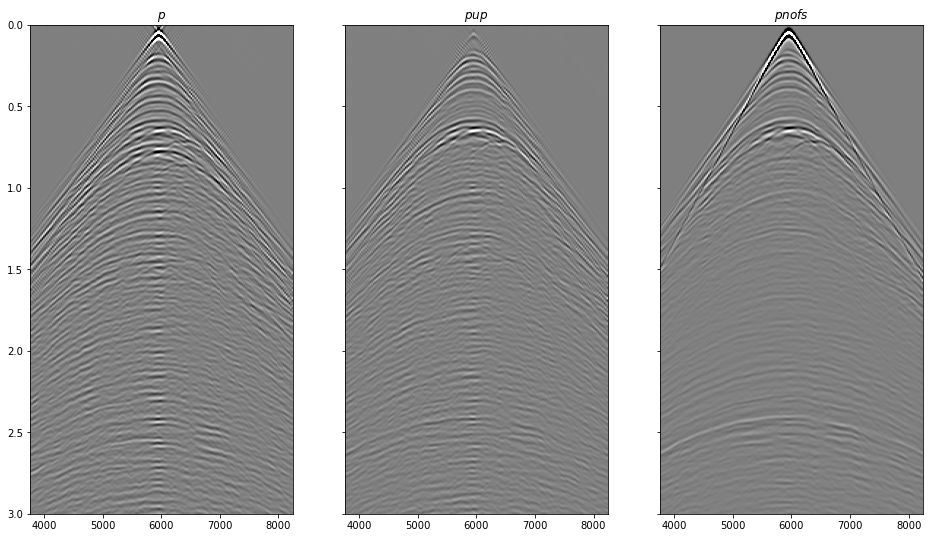

In [5]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16,9))
axs[0].imshow(pup[:, 59]+pdown[:, 59], cmap='gray', vmin=-0.1*np.abs(pdown).max(), vmax=0.1*np.abs(pdown).max(),
              extent = (rsynth[0, 0], rsynth[0,-1], t[-1], t[0]))
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[1].imshow(pup[:, 59], cmap='gray', vmin=-0.1*np.abs(pdown).max(), vmax=0.1*np.abs(pdown).max(),
              extent = (rsynth[0, 0], rsynth[0,-1], t[-1], t[0]))
axs[1].set_title(r'$pup$')
axs[1].axis('tight')
axs[2].imshow(psynth_nofs[59].T, cmap='gray', vmin=-1e3, vmax=1e3,
              extent = (rsynth[0,0],rsynth[0,-1], tsynth[-1], tsynth[0]))
axs[2].set_title(r'$pnofs$')
axs[2].axis('tight')
axs[2].set_ylim(3, 0);

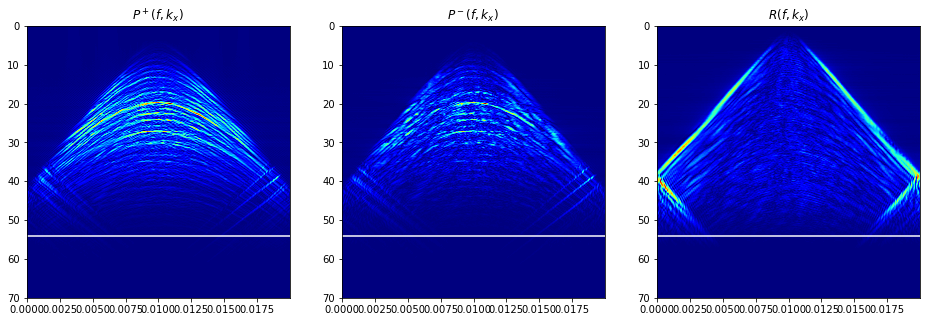

In [6]:
# Define frequency range
nfft = nt
nfmax = 230
FFTop = FFT2D(dims=[nr, nt], 
              nffts=[nfft, nfft], sampling=[dr, dt])

PUP = (FFTop*pup[:, ns//2].T.flatten()).reshape(nfft, nfft)
PDOWN = (FFTop*pdown[:, ns//2].T.flatten()).reshape(nfft, nfft)
RTRUE = (FFTop*psynth_noseaflat.T.ravel()).reshape(nfft, nfft)

mask = np.zeros((nfft, nfft))
mask[:, :nfmax] = 1
mask[:, -nfmax:] = 1
mask = filtfilt(np.ones(50)/50, 1, mask, axis=1)
RTRUE *= mask
Rtrue = np.real(FFTop.H * RTRUE.ravel()).reshape(nr, nt).T
nfmax += 30 # Add some extra frequencies where Rtrue has not been cut to zero (inside taper)

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
im=axs[0].imshow(np.fft.fftshift(np.abs(PDOWN[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(PDOWN).max())
axs[0].axhline(FFTop.f2[nfmax], color='w')
axs[0].set_title(r'$P^+(f, k_x)$')
axs[0].axis('tight')
axs[0].set_ylim(70, 0);
im=axs[1].imshow(np.fft.fftshift(np.abs(PUP[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(PDOWN).max())
axs[1].axhline(FFTop.f2[nfmax], color='w')
axs[1].set_title(r'$P^-(f, k_x)$')
axs[1].axis('tight');
axs[1].set_ylim(70, 0)
im=axs[2].imshow(np.fft.fftshift(np.abs(RTRUE[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(RTRUE).max())
axs[2].axhline(FFTop.f2[nfmax], color='w')
axs[2].set_title(r'$R(f, k_x)$')
axs[2].axis('tight')
axs[2].set_ylim(70, 0);

In [7]:
# TX mask
mask = np.fft.fftshift(mask_xt(np.abs(rsynth[0]-rsynth[0, np.newaxis].T) / 1900, t[:nt//2+1], 0, 10), axes=0)
mask[nt//2-40:nt//2+600] = 1.
Mop = Diagonal(mask[:, nr//2].ravel())

# MDD parameters
reciprocity = True
nvsin = 0
nvsend = nr
nvs = nvsend-nvsin

In [12]:
# MDC operator
PDOWN = np.fft.rfft(pdown, nt, axis=0)
PDOWN = PDOWN[:nfmax]

MDCop = MDC(PDOWN, nt=nt,
            nv=nr, dt=dt, dr=dr, 
            twosided=False, transpose=False)

# Time mask
Mop = Diagonal(mask.ravel())

# Reciprocity prec
if reciprocity:
    Recop =  0.5 * (Identity(nt * nr * nr) + \
            Transpose((nt, nr, nr), (0, 2, 1)))
    MDCop = MDCop * Mop * Recop
else:
    MDCop = MDCop * Mop

# Adjoint
Radj = MDCop.H * pup[:, :, nvsin:nvsend].ravel()
Radj = np.real(Radj).reshape(nt, nr, nvs)

In [13]:
# Inversion
Rinv, _, _, _, _, bench_resnorm = \
    cgls(MDCop, pup[:, :, nvsin:nvsend].ravel(), niter=niter, 
         x0=np.zeros((nt, nr, nvs)).ravel(), damp=1e-9, tol=0., show=1)
Rinv = np.real(Mop * Recop * Rinv).reshape(nt, nr, nr)

pupinv = MDCop * Rinv.ravel()
pupinv = pupinv.reshape(nt, ns, nvs)

CGLS
-----------------------------------------------------------
The Operator Op has 47539800 rows and 77792400 cols
damp = 1.000000e-09	tol = 0.000000e+00	niter = 30
-----------------------------------------------------------
    Itn           x[0]              r1norm          r2norm
     1        -9.2842e-04         1.0503e+06      1.0503e+06
     2        -1.6888e-03         9.0133e+05      9.0133e+05
     3        -2.1901e-03         8.3010e+05      8.3010e+05
     4        -2.6658e-03         7.7861e+05      7.7861e+05
     5        -3.1215e-03         7.4168e+05      7.4168e+05
     6        -3.5313e-03         7.1623e+05      7.1623e+05
     7        -3.9416e-03         6.9643e+05      6.9643e+05
     8        -4.3543e-03         6.8067e+05      6.8067e+05
     9        -4.7593e-03         6.6834e+05      6.6834e+05
    10        -5.1634e-03         6.5848e+05      6.5848e+05
    20        -8.6764e-03         6.1713e+05      6.1713e+05
    21        -8.9690e-03         6.1534e+0

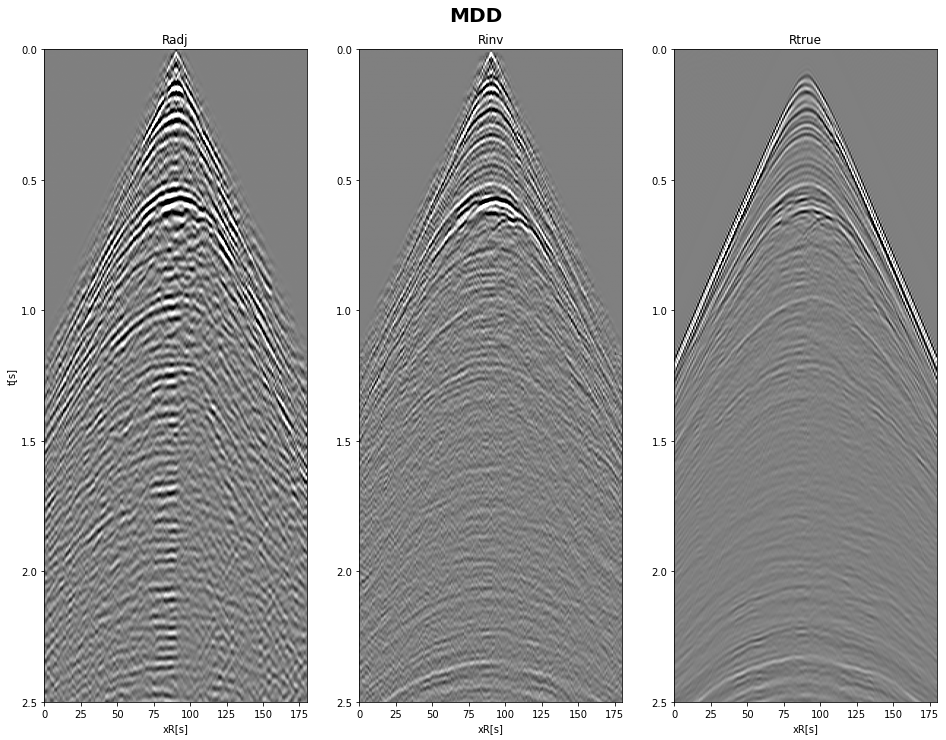

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(16, 12))
fig.suptitle('MDD', y=0.93, fontsize=20, fontweight='bold')
axs[0].imshow(Radj[:itmax, :, ivs], cmap='gray', 
              vmin=-clip*np.abs(Radj[:itmax:, :, ivs]).max(), 
              vmax=clip*np.abs(Radj[:itmax:, :, ivs]).max(),
              extent = (0, nr, t[itmax], 0))
axs[0].set_ylabel('t[s]')
axs[0].set_xlabel('xR[s]')
axs[0].set_ylabel('t[s]')
axs[0].set_title('Radj')
axs[0].axis('tight')
axs[0].set_ylim(2.5, 0)
axs[1].imshow(Rinv[:itmax:, :, ivs], cmap='gray', 
              vmin=-clip*np.abs(Rinv[:itmax:, :, ivs]).max(),
              vmax=clip*np.abs(Rinv[:itmax:, :, ivs]).max(),
              extent = (0, nr, t[itmax], 0))
axs[1].set_xlabel('xR[s]')
axs[1].set_title('Rinv')
axs[1].axis('tight')
axs[1].set_ylim(2.5, 0)
axs[2].imshow(Rtrue[:itmax], cmap='gray', 
              vmin=-clip*np.abs(Rtrue[:itmax]).max(), 
              vmax=clip*np.abs(Rtrue[:itmax]).max(),
              extent = (0, nr, t[itmax], 0))
axs[2].set_xlabel('xR[s]')
axs[2].set_title('Rtrue')
axs[2].axis('tight')
axs[2].set_ylim(2.5, 0)
plt.savefig('../Figures/Volve_synthdata_mdd.png');